# DNI Estimation Model Validation
The purpose of this notebook is to validate the use of new or current DNI estimation models through multiple steps of analysis

<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import Data


In [2]:
#read in data from duramat datahub directly
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

In [3]:
#Defining constants and values that are consistent across all calculations
#we are using S2 from the data, which is the Candian Solar Monocrystalline 275W module
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,
         'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'Alpha Isc':0.0033,
          'Beta Voc': -0.1178, 'Cell Type':'monoSi', 'Cells in Series':60}
module = pd.Series(module)

#Running solar position calculations
spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['AOI'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'],solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
df['Airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = df['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925


In [4]:
#Calculate Environmental Conditions
edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=df['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

#Calculate Effective Irradiance
ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
F2 = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * F2 + edf['poa_diffuse'])
df['IAMs'] = F2

## 3. Run the model or import the results to be validated

In [5]:
#Either run a model in this notebook or import the results into the column name below

df['Modeled DNI'] = pvlib.irradiance.dirint(ghi=df['GHI (W/m2)'], solar_zenith=df['Zenith'], times=df.index)

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled DNI'] = pd.read_excel('results.xlsx')

#specify a model name for use in analysis and plotting
model_name = 'Dirint'

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious extreme errors like time shifts or magnitude differences

Text(0.5, 0, 'Time')

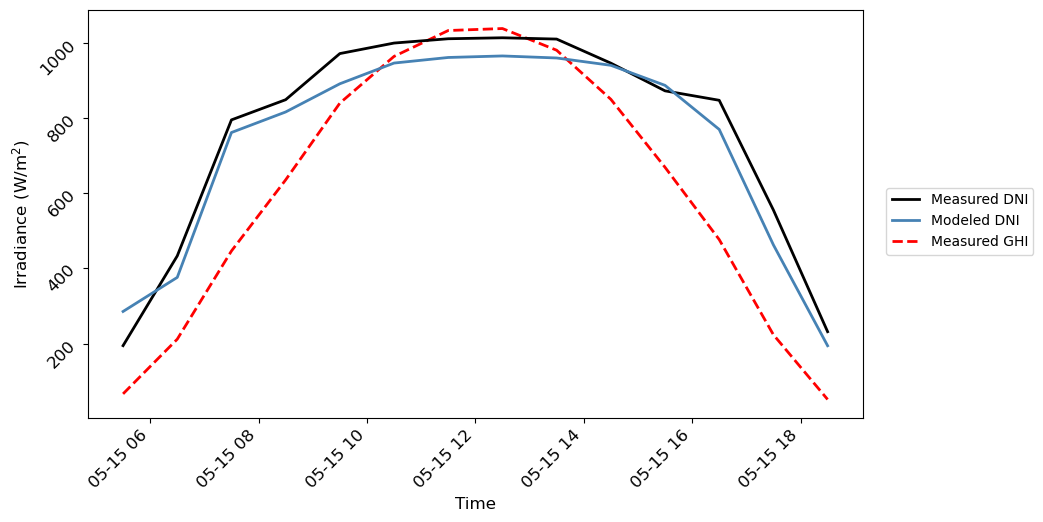

In [6]:
#diurnal plot

date = '2021-05-15'
fig, ax = plt.subplots()
df.loc[date, 'DNI (W/m2)'].plot(ax=ax, label='Measured DNI', linewidth=2, color='black', zorder=5.5)
df.loc[date, 'Modeled DNI'].plot(ax=ax, label='Modeled DNI', linewidth=2, color='steelblue', zorder=5.5)
df.loc[date, 'GHI (W/m2)'].plot(ax=ax, label='Measured GHI', linewidth=2, color='red', zorder=2.5, linestyle='dashed')

ax.legend(prop=dict(size='small'), loc=[1.03, 0.4])
ax.tick_params(labelrotation=45)
ax.set_ylabel('Irradiance (W/m$^2$)')
ax.set_xlabel('Time')

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Mean Bias Error (NMBE) - shows the estimation bias of the model
###                 $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [7]:
#fractional values seen with DNI cause normalized errors to appear disproportionately large, so absolute units only are used  here
df['NBE'] = 100 * (df['Modeled DNI'] - df['DNI (W/m2)'])/(df['DNI (W/m2)'])
df['BE'] = (df['Modeled DNI'] - df['DNI (W/m2)'])
mbe = df['BE'].mean()
rmse = (df['BE']**2).mean()**0.5

d = [['MBE', str(round(mbe,3))+' W/m2'], ['RMSE',str(round(rmse,3))+' W/m2']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  ------------
MBE       -29.031 W/m2
RMSE      76.972 W/m2


### Plotting the measured vs modeled values
The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

Text(200, 950, '1.0161x + 19.0871')

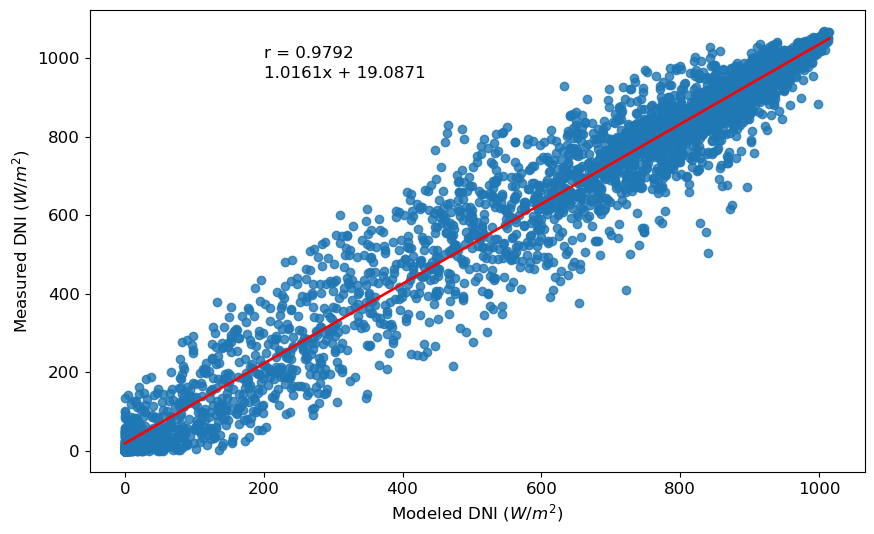

In [8]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled DNI'], y = df.dropna()['DNI (W/m2)'])
sns.regplot(x = df['Modeled DNI'], y = df['DNI (W/m2)'], line_kws={'color':'red'})

plt.ylabel('Measured DNI ($W/m^2$)')
plt.xlabel('Modeled DNI ($W/m^2$)')
plt.text(200, 1000, s = ("r = "+str(round(r,4))))
plt.text(200, 950, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))

### Energy Yield Estimates
We can run two simulations, one using the POA model and another using true POA data to see how much influence the errors of the model have on the overall energy yield

In [9]:
#using measured POA to estimate energy
df['DC Power - Meas DNI'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], df['Measured front POA irradiance (W/m2)'], deltaT=3),
                                    pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
#using modeled POA to estimate energy

dni_edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth = module['Surface Azimuth'], solar_zenith = df['Zenith'], solar_azimuth = df['Azimuth'],
                                    dni = df['Modeled DNI'], ghi = df['GHI (W/m2)'], dhi = df['DHI (W/m2)'], dni_extra=df['dni_extra'],model='perez')
df['Effective Irradiance - Model DNI'] = (dni_edf['poa_direct'] * F2 + dni_edf['poa_diffuse'])
df['DC Power - Model DNI'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance - Model DNI'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], dni_edf['poa_direct'], deltaT=3),
                                    pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])
#find overall % diff for annual energy
print('With measured DNI, predicted annual energy is', round(df['DC Power - Meas DNI'].sum()/1000,3),
      'kWh and with modeled DNI, predicted annual energy is', round(df['DC Power - Model DNI'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using measured vs modeled DNI is ', round(((df['DC Power - Model DNI'].sum()-df['DC Power - Meas DNI'].sum())/df['DC Power - Meas DNI'].sum())*100,3),'%')

With measured DNI, predicted annual energy is 6705.343 kWh and with modeled DNI, predicted annual energy is 6606.113 kWh
The % difference in energy estimate when using measured vs modeled DNI is  -1.48 %


C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\1618837419.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bins['Energy - Model DNI'] = df.groupby('Irradiance Bins').sum()['DC Power - Model DNI']/1000
C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\1618837419.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bins['Energy - Meas DNI'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas DNI']/1000
C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\1618837419.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='Irradiance Bins

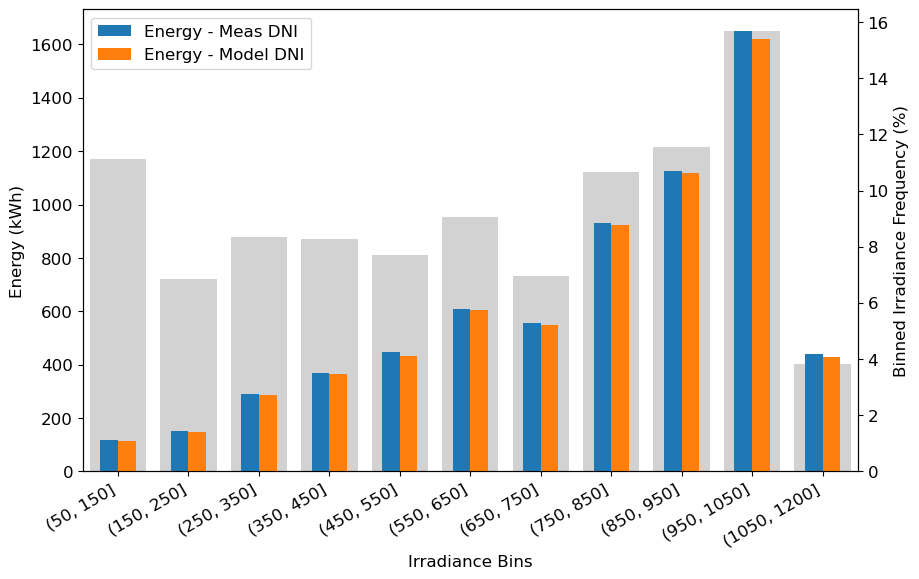

In [10]:
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

bins['Energy - Model DNI'] = df.groupby('Irradiance Bins').sum()['DC Power - Model DNI']/1000
bins['Energy - Meas DNI'] = df.groupby('Irradiance Bins').sum()['DC Power - Meas DNI']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Meas DNI", "Energy - Model DNI"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)


# plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

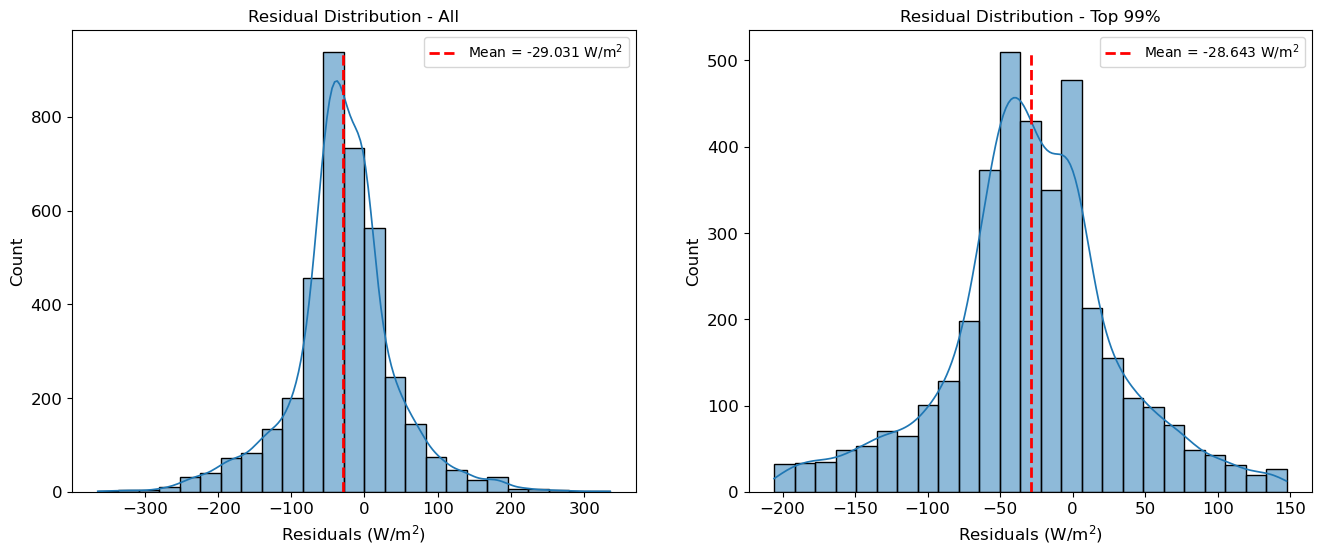

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = (df['Modeled DNI'] - df['DNI (W/m2)'])
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W/m$^2$'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W/m$^2$)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W/m$^2$'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

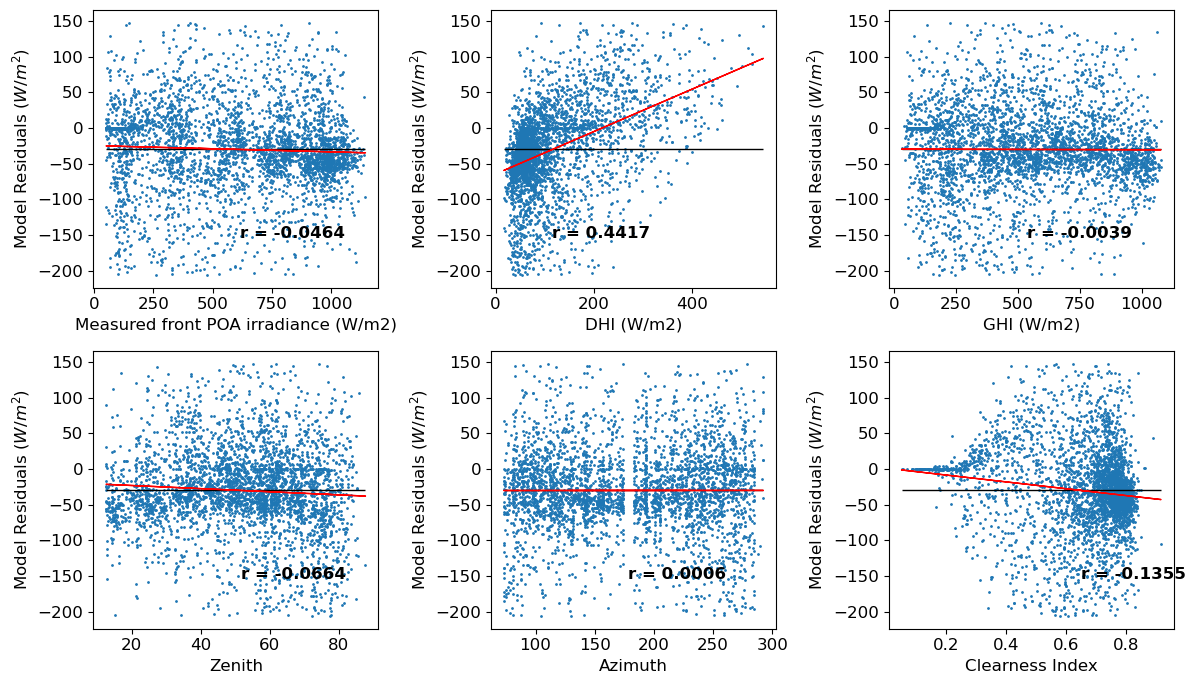

In [15]:
#plot residuals against common inputs into POA models

df = df.dropna()

covariates = [
    'Measured front POA irradiance (W/m2)', 'DHI (W/m2)', 'GHI (W/m2)',
    'Zenith', 'Azimuth', 'Clearness Index'
]

y = df['resid_trim']
y_avg = df['resid_trim'].mean()
y_med = df['resid_trim'].median()

fig, axes = plt.subplots(2, 3, figsize=(12, 7))

for covariate, ax in zip(covariates, axes.flatten()):
    x = df[covariate]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r = np.corrcoef(x, y)[0][1]
    
    ax.scatter(x, y, s=1)
    ax.hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black', linestyles='-')
    ax.text(x=x.mean(), y=(y.min() + (-0.25*y.min())), s=f"r = {r:0.04f}", weight='bold')
    ax.plot(x, p(x), linewidth=1, color='red')
    ax.set_xlabel(covariate)
    ax.set_ylabel('Model Residuals ($W/m^2$)')

fig.tight_layout()

## Plotting residuals vs AOI with division of some metric (Hour, Clearness Index, etc)
#### Describes time of day dependence

Text(0.5, 1.0, 'Residuals of Model at High and Low Clearness Index levels')

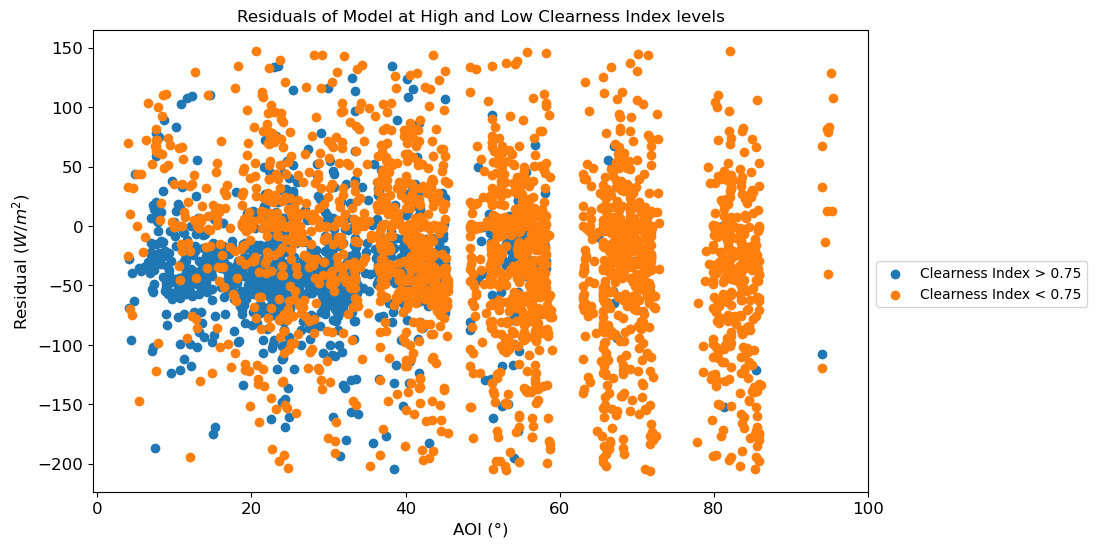

In [17]:
metric = 'Clearness Index'
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

plt.scatter(x=df_h['AOI'], y=df_h['resid_trim'], label=(metric+' > '+str(bound)))
plt.scatter(x=df_l['AOI'], y=df_l['resid_trim'], label=(metric+' < '+str(bound)))

plt.ylabel('Residual ($W/m^2$)')
plt.xlabel('AOI (°)')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.title('Residuals of Model at High and Low '+metric+' levels')

### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

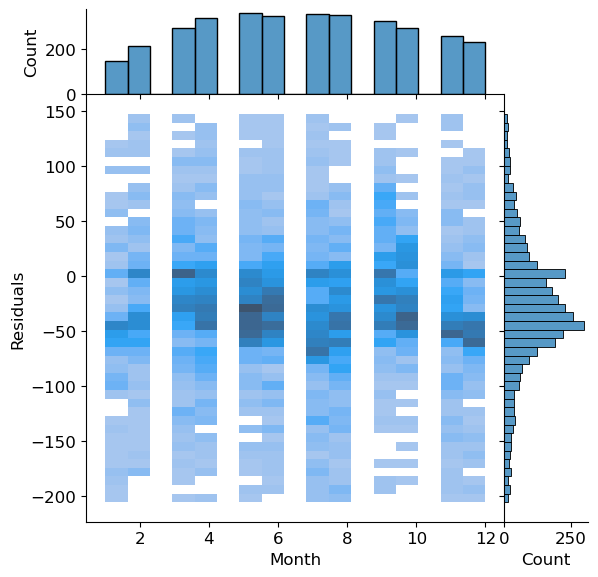

In [18]:
sns.jointplot(data=df, x='Month', y='Residuals', kind='hist', space=0, marginal_ticks=True)

Text(0.5, 1.0, 'Model Residuals by Month')

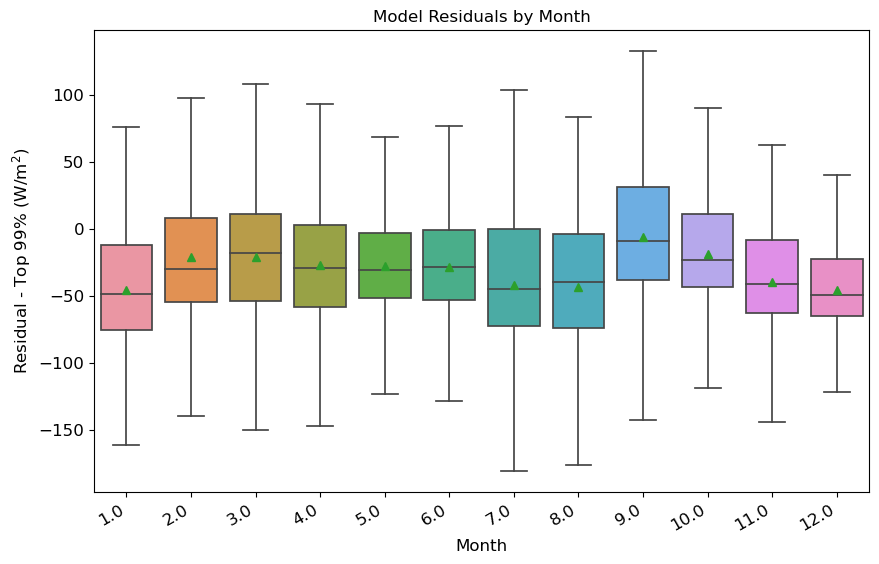

In [19]:
sns.boxplot(data=df, x='Month', y='resid_trim', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Residual - Top 99% (W/m$^2$)')
plt.title('Model Residuals by Month')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

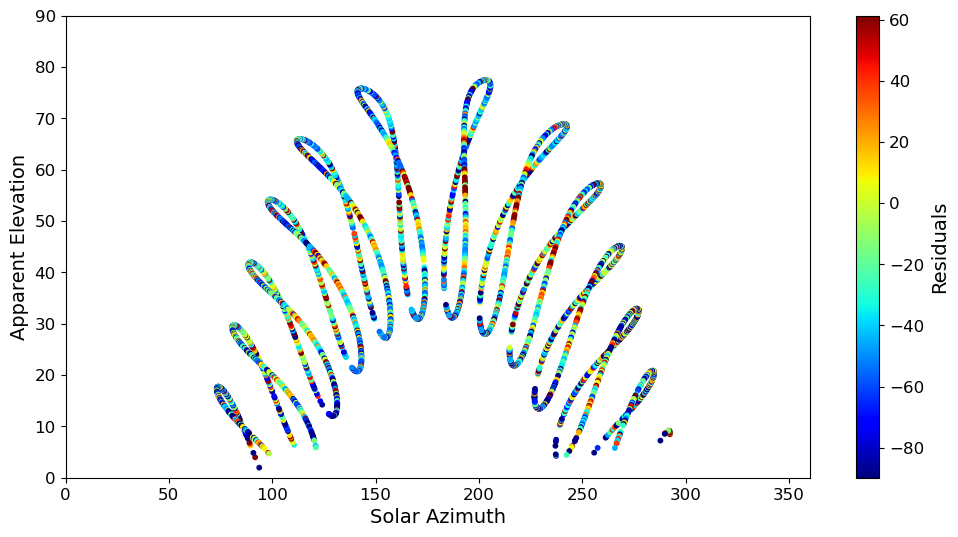

In [20]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['resid_trim'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('Residuals',fontsize =14)
plt.clim((df['resid_trim'].describe()['mean'] - df['resid_trim'].describe()['std']),(df['resid_trim'].describe()['75%'] + df['resid_trim'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line


Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

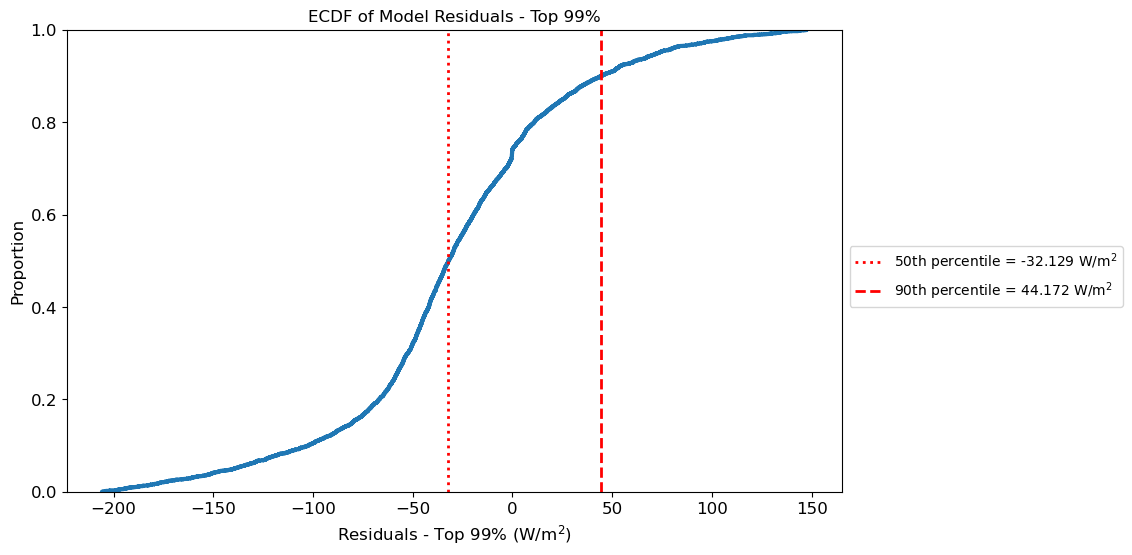

In [25]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W/m$^2$)')
perc50 = df['resid_trim'].quantile(0.5)
perc90 = df['resid_trim'].quantile(0.9)
plt.axvline(perc50, linewidth=2, color='red', linestyle='dotted', label=f'50th percentile = {perc50:0.03f} W/m$^2$')
plt.axvline(perc90, linewidth=2, color='red', linestyle='--', label=f'90th percentile = {perc90:0.03f} W/m$^2$')
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4])
plt.title('ECDF of Model Residuals - Top 99%')

Text(0.5, 1.0, 'ECDF of Model at High and Low Clearness Index levels')

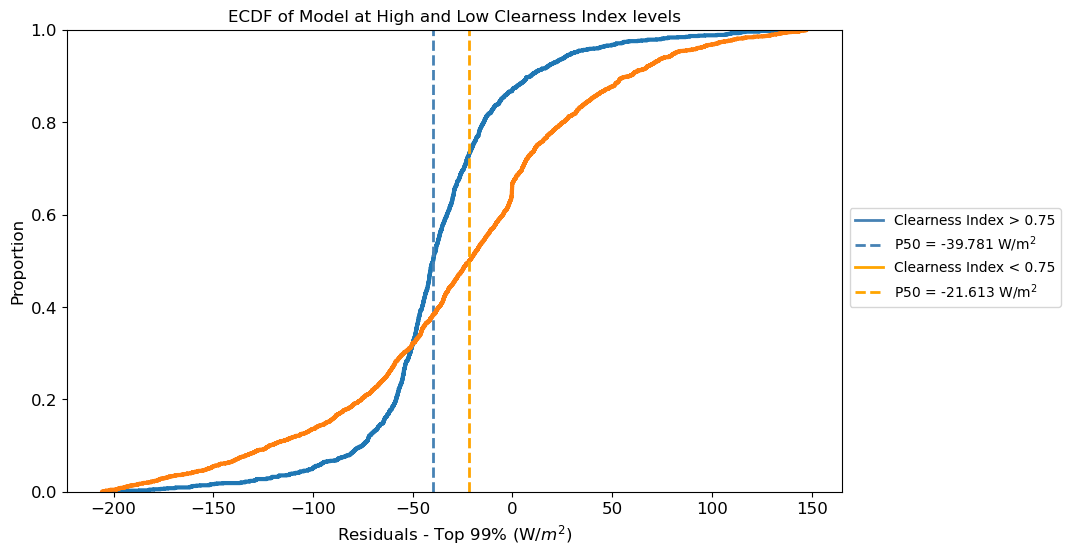

In [26]:
metric = 'Clearness Index' #other options could be clearness index, month, etc
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_h['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_l['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')


plt.xlabel('Residuals - Top 99% (W/$m^2$)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_h['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_l['resid_trim'].dropna(), 50),3))+' W/m$^2$'))
lines = [line_1,line_2,line_3, line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)

plt.title('ECDF of Model at High and Low '+metric+' levels')

### Analysis III: Comparison to Baseline Models
##### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models


In [35]:
df['Baseline Model DNI'] = pvlib.irradiance.disc(ghi=df['GHI (W/m2)'], solar_zenith=df['Zenith'], datetime_or_doy = df.index)['dni']

df['Baseline Residuals'] = df['Baseline Model DNI'] - df['DNI (W/m2)']
baseline_model = 'Disc'

In [36]:
bdni_df = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth = module['Surface Azimuth'], solar_zenith = df['Zenith'], solar_azimuth = df['Azimuth'],
               dni = df['Baseline Model DNI'], ghi = df['GHI (W/m2)'], dhi = df['DHI (W/m2)'], dni_extra=df['dni_extra'],model='perez')
df['Effective Irradiance - Baseline Model DNI'] = (bdni_df['poa_direct'] * F2 + bdni_df['poa_diffuse'])
df['DC Power - Baseline Model DNI'] = module['String Length']*pvlib.pvsystem.pvwatts_dc(g_poa_effective=df['Effective Irradiance - Baseline Model DNI'], 
                                    temp_cell=pvlib.temperature.sapm_cell_from_module(df['Measured module temperature (°C)'], bdni_df['poa_global'], deltaT=3),
                                    pdc0=module['Pmp'], gamma_pdc=module['Gamma Pmp'])

In [37]:
#find overall % diff for annual energy
print('With the initial DNI estimation model, predicted annual energy is', round(df['DC Power - Model DNI'].sum()/1000,3),
      'kWh and with the baseline modeled DNI, predicted annual energy is', round(df['DC Power - Baseline Model DNI'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using the initial model vs the baseline DNI estimation model ', 
      round(((df['DC Power - Baseline Model DNI'].sum()-df['DC Power - Model DNI'].sum())/df['DC Power - Model DNI'].sum())*100,3),'%')

With the initial DNI estimation model, predicted annual energy is 6379.911 kWh and with the baseline modeled DNI, predicted annual energy is 6362.006 kWh
The % difference in energy estimate when using the initial model vs the baseline DNI estimation model  -0.281 %


Text(0.5, 1.0, 'Overall NMBE for Model & Baseline Model')

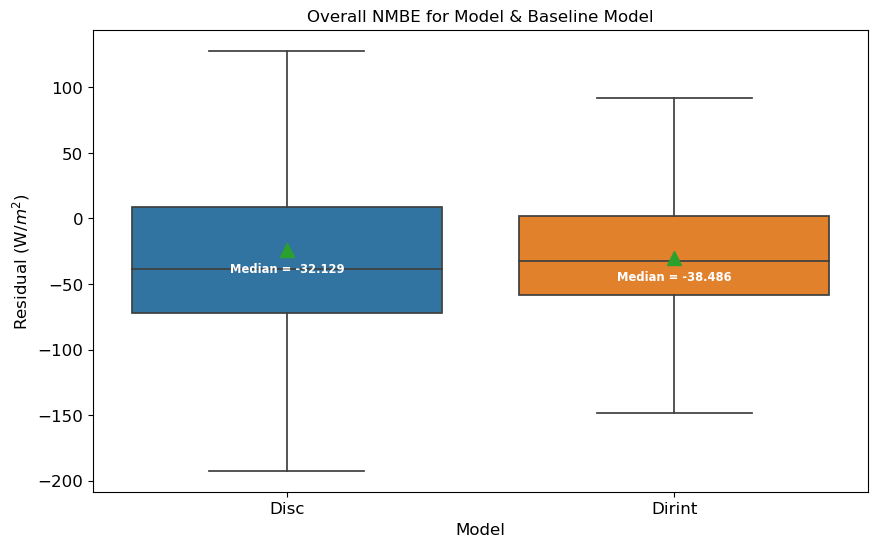

In [38]:
resid_df = pd.concat([
    pd.DataFrame({
        'Residual': df['Baseline Model DNI'] - df['DNI (W/m2)'],
        'Model': baseline_model,
    }),
    pd.DataFrame({
        'Residual': df['Modeled DNI'] - df['DNI (W/m2)'],
        'Model': 'Dirint',
    })
], ignore_index=True)

box_plot = sns.boxplot(x='Model', y='Residual', data=resid_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('Residual (W/$m^2$)')
medians = resid_df.groupby(['Model'])['Residual'].median()
vertical_offset = resid_df['Residual'].median() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,('Median = '+str(round(medians[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Overall NMBE for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model & Baseline Model Residuals')

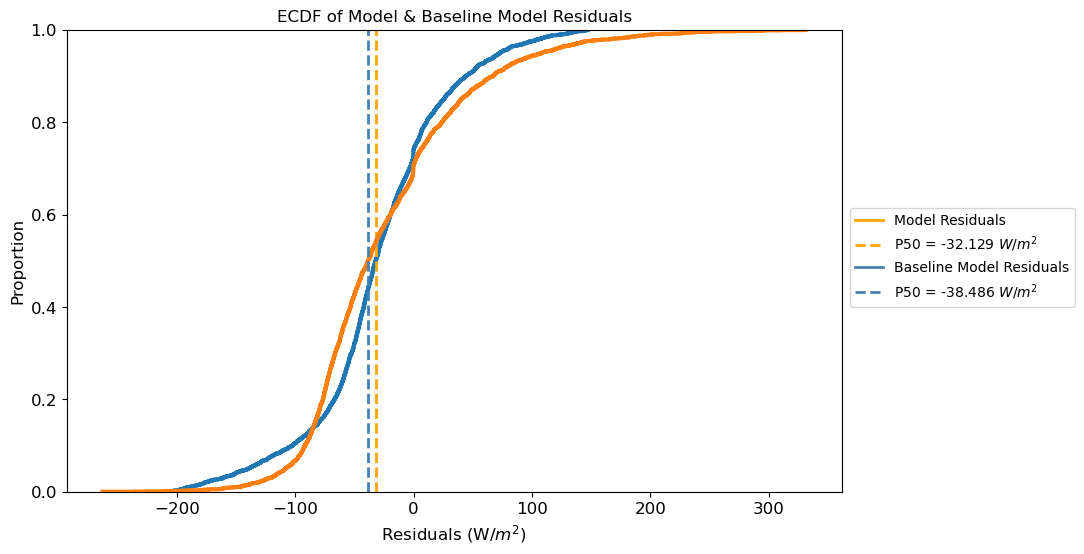

In [39]:
#ecdf of the two models overlayed & p50 given
sns.ecdfplot(data=df, x='Residuals', linewidth=3)
plt.vlines(x=np.percentile(df['Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')
sns.ecdfplot(data=df, x='Baseline Residuals',linewidth=3)
plt.vlines(x=np.percentile(df['Baseline Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')


plt.xlabel('Residuals (W/$m^2$)')
line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Model Residuals')
line_2 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 50),3))+' $W/m^2$'))
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model Residuals')
line_4 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Baseline Residuals'].dropna(), 50),3))+' $W/m^2$'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model & Baseline Model Residuals')

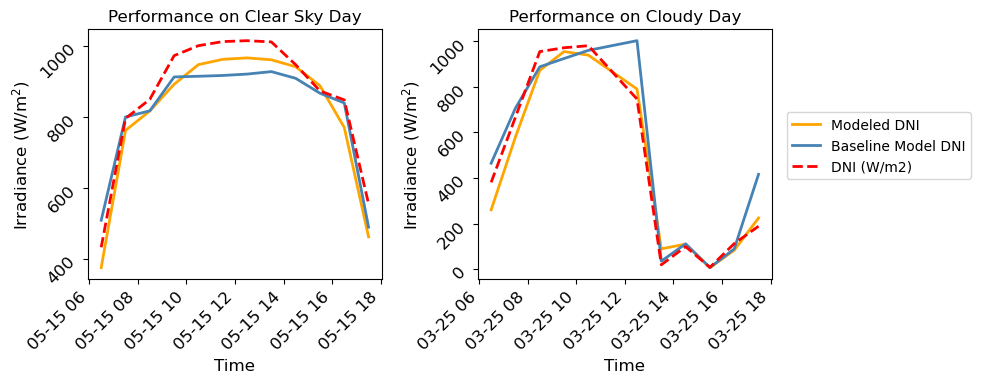

In [49]:
# diurnal plots

dates = [
    ('Clear Sky', '2021-05-15'),
    ('Cloudy', '2021-03-25'),
]

fig, axes = plt.subplots(1, len(dates), figsize=(10,4))

for (sky_condition, date), ax in zip(dates, axes):
    df.loc[date, 'Modeled DNI'].plot(ax=ax, linewidth=2, color='orange')
    df.loc[date, 'Baseline Model DNI'].plot(ax=ax, linewidth=2, color='steelblue')
    df.loc[date, 'DNI (W/m2)'].plot(ax=ax, linewidth=2, linestyle='dashed', color='red')
    ax.tick_params(labelrotation = 45)
    ax.set_ylabel('Irradiance (W/m$^2$)')
    ax.set_xlabel('Time')
    ax.set_title(f'Performance on {sky_condition} Day')

axes[-1].legend(prop=dict(size='small'), loc=[1.05, 0.4])
fig.tight_layout()

C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\484779825.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby('Irradiance Bins').mean()['Residuals']
C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\484779825.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby('Irradiance Bins').mean()['Baseline Residuals']
C:\Users\ksande\AppData\Local\Temp\ipykernel_33528\484779825.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder

Text(0.5, 1.0, 'Residuals of models in different irradiance bins')

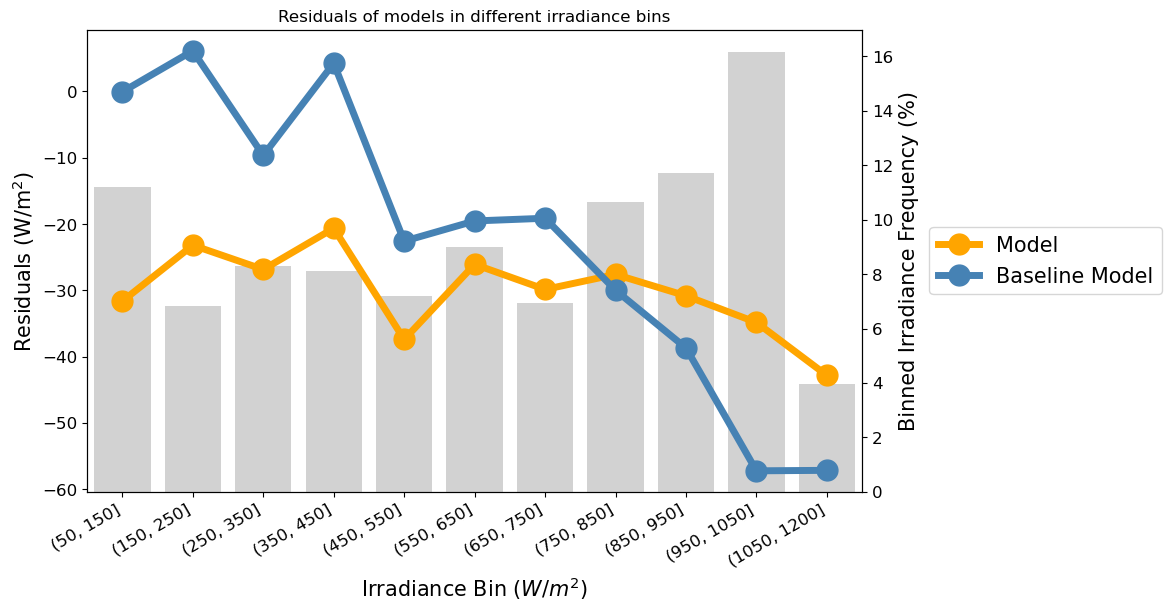

In [45]:
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean()['Residuals']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df.groupby('Irradiance Bins').mean()['Baseline Residuals']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('Residuals (W/m$^2$)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
#ax.set_title(system+ ' System')
ax.legend(['Model','Baseline Model'],loc='center right',bbox_to_anchor=(1.4, 0.5), fontsize=15)
#ax.set_ylim(-5,10)


ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('Residuals of models in different irradiance bins')